<a href="https://colab.research.google.com/github/Annie2603/CS726-Morpheus/blob/main/Defence/Code/morph_defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#@title Setup diffae

from IPython.display import clear_output 

%cd /content/
!git clone https://github.com/phizaz/diffae

%cd /content/diffae/
!mkdirs checkpoints/ checkpoints/ffhq128_autoenc_72M
!gdown 19yus_mOas9hkkBB6g3vRrybcsF4xahFg -O checkpoints/ffhq128_autoenc_72M/
!gdown 15Ga37K_teP_63od9b3nVhmJFJsCxRLF2 -O checkpoints/ffhq128_autoenc_72M/

!mv checkpoints/ffhq128_autoenc_72M/last.ckpt checkpoints/ffhq128_autoenc_72M/trained.ckpt
!mv checkpoints/ffhq128_autoenc_72M/last1.ckpt checkpoints/ffhq128_autoenc_72M/last.ckpt

clear_output()
print("Done")

Done


In [ ]:
%%capture
#@title Setup Environment (will restart runtime)
#@ Setup environment
#you may not need all the dev libraries, but I haven't tested which aren't necessary.
!sudo apt-get update -y
!sudo apt-get install python3.8 python3.8-dev python3.8-distutils libpython3.8-dev

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 2

#Check that it points at the right location
!python3 --version

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.10/dist-packages/google \
       /usr/local/lib/python3.8/dist-packages/google

# There has got to be a better way to do this...but there's a bad import in some of the colab files
# IPython no longer exposes traitlets like this, it's a separate package now
!sed -i "s/from IPython.utils import traitlets as _traitlets/import traitlets as _traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py
!sed -i "s/from IPython.utils import traitlets/import traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py


clear_output()

!python3 -m pip install -r '/content/diffae/requirements.txt'
!python3 -m pip install matplotlib
!python3 -m pip install gdown


clear_output()
print("Requirements installed, restarting runtime...")

import os
os.kill(os.getpid(), 9)

In [1]:
!python3 --version

import sys
sys.version

Python 3.8.10


'3.8.10 (default, Mar 13 2023, 10:26:41) \n[GCC 9.4.0]'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/content/diffae/")
%cd /content/diffae

/content/diffae


In [4]:
from templates import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = 'cuda:0'
conf = ffhq128_autoenc_72M()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


Model params: 122.59 M


In [ ]:
!cp imgs_align/sandy.png imgs_interpolate/sandy.png
data = ImageDataset('imgs_interpolate', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[2]['img'],
    data[1]['img'],
])

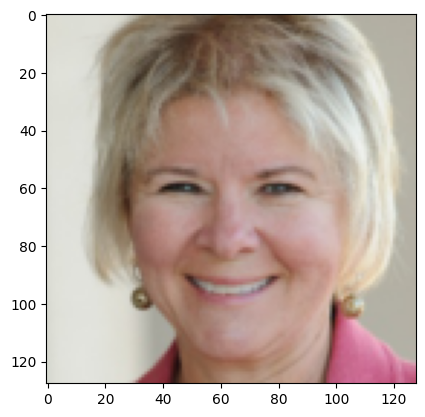

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]).float() / 2 + 0.5)

In [ ]:
cond = model.encode(batch.to(device)).type(torch.float16)
xT = model.encode_stochastic(batch.to(device), cond, T=250).type(torch.float16)

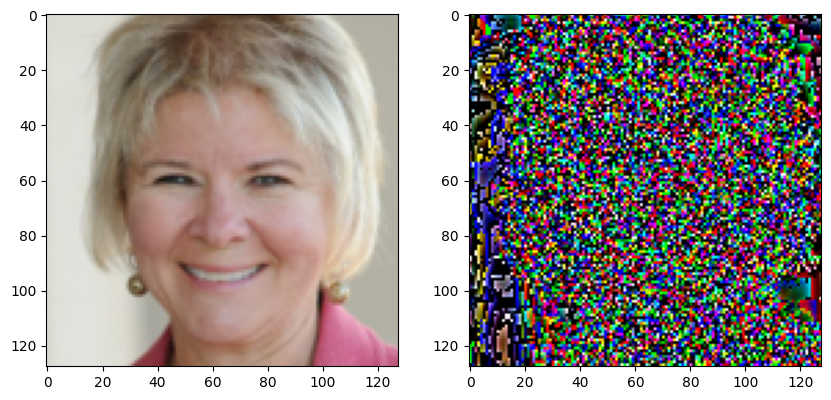

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu().float())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu().float())

# Interpolation


In [ ]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float16)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()
    
theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=10)

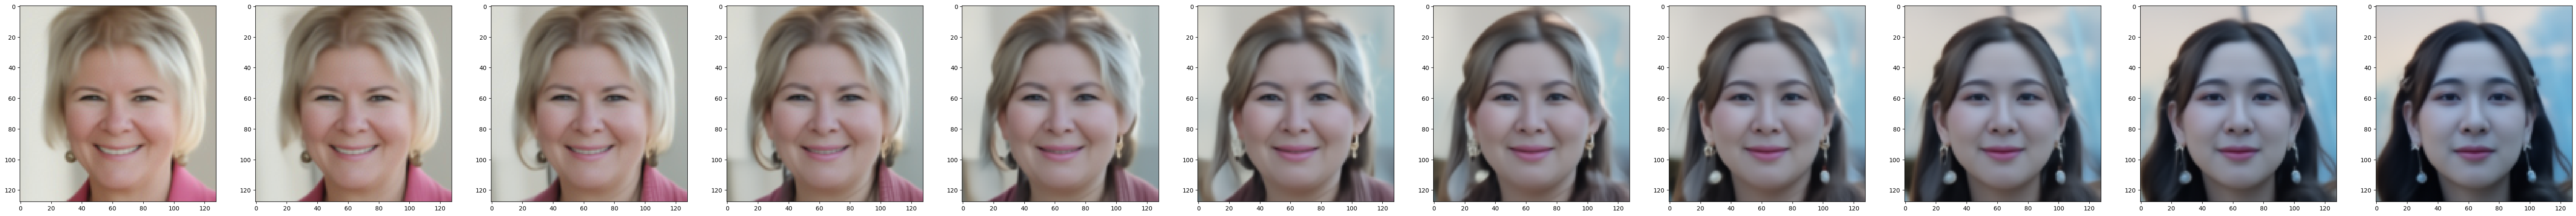

In [ ]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, len(alpha), figsize=(7*len(alpha), 7))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')

In [ ]:
def morph_pair_with_cond(cond, xT, num=3, out_T=10, alpha_overrides=[]):
    alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float16)).to(cond.device)
    
    num = num if num != -1 else False
    if num:
        sel = set([5]).union(set([3,7])).union(alpha_overrides)
        alpha = alpha[list(sel)].sort().values

    intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

    def cos(a, b):
        a = a.view(-1)
        b = b.view(-1)
        a = F.normalize(a, dim=0)
        b = F.normalize(b, dim=0)
        return (a * b).sum()
        
    theta = torch.arccos(cos(xT[0], xT[1]))
    x_shape = xT[0].shape
    intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
    intp_x = intp_x.view(-1, *x_shape)

    pred = model.render(intp_x, intp, out_T)

    return pred, alpha

def get_partially_morphed(batch, batch_idxs, num_pairs=1, pred_T=100, out_T=20, num_per=2):
    cond = model.encode(batch.to(device)).type(torch.float16)
    xT = model.encode_stochastic(batch.to(device), cond, T=pred_T).type(torch.float16)

    out = torch.tensor([])
    labels = torch.tensor([])
    pairs_morphed = []
    choicelist = list(range(len(cond)))
    for i in range(num_pairs):
        if len(choicelist) < 2: break
        pair_indices = np.random.choice(choicelist,size=2,replace=False)
        choicelist.remove(pair_indices[0])
        choicelist.remove(pair_indices[1])

        cond_ = cond[pair_indices]
        xT_ = xT[pair_indices]
        fakes, _ = morph_pair_with_cond(cond_, xT_, num=num_per, out_T=20, alpha_overrides=[0,10])

        out = torch.cat((out.to(fakes.device), fakes))
        labels_ = [1] + [0] * (len(fakes)-2) + [1]
        labels = torch.cat((labels, torch.tensor(labels_)))

        pairs_morphed.append(batch_idxs[pair_indices])

    for remaining in choicelist:
        out = torch.cat((out, (batch[remaining:remaining+1]/2 + 0.5).to(out.device)))
        labels = torch.cat((labels, torch.tensor([1])))

    return out.cpu(), labels.cpu(), pairs_morphed

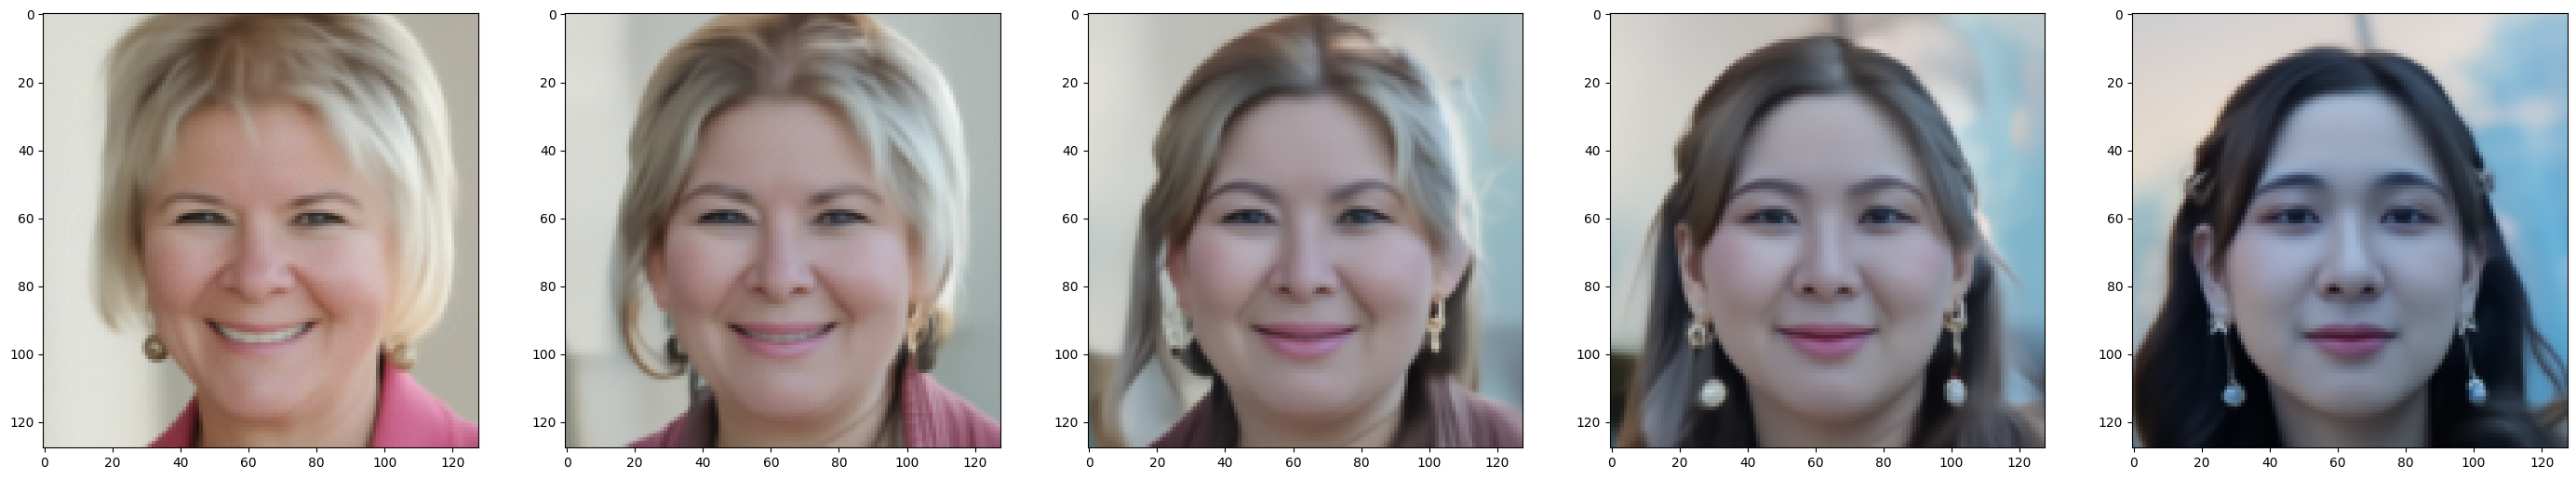

In [ ]:
pred_T=100; out_T=20
batch = torch.stack([
        data[1]['img'],
        data[2]['img'],
    ])

batch_idx = torch.tensor([
        data[1]['index'],
        data[2]['index'],
    ])

fakes, labels, pairs = get_partially_morphed(batch, batch_idx, num_per=2)

fig, ax = plt.subplots(1, len(fakes), figsize=(7*len(fakes), 7))
for i in range(len(fakes)):
    if len(fakes)>1: ax[i].imshow(fakes[i].permute(1, 2, 0).cpu())
    else: ax.imshow(fakes[i].permute(1, 2, 0).cpu())
    # ax[i].set_title(round(alpha[i].item(),1))

# Creating fake face dataset

In [ ]:
!mkdir '/content/diffae/datasets/ffhq256.lmdb'
%cd /content/diffae/datasets/ffhq256.lmdb
!gdown 1GiSWN1fpaLmxmgoe06nsBCINb8qTso3P
!gdown 172Vbxv7sA0kdbOQKHaXEZY8prBDvXO6C

%cd /content/diffae/

mkdir: cannot create directory ‘/content/diffae/datasets/ffhq256.lmdb’: File exists
/content/diffae/datasets/ffhq256.lmdb
Downloading...
From (uriginal): https://drive.google.com/uc?id=1GiSWN1fpaLmxmgoe06nsBCINb8qTso3P
From (redirected): https://drive.google.com/uc?id=1GiSWN1fpaLmxmgoe06nsBCINb8qTso3P&confirm=t&uuid=7c6451a1-262c-4531-8ae0-572c3b0e8527
To: /content/diffae/datasets/ffhq256.lmdb/lock.mdb
100% 8.19k/8.19k [00:00<00:00, 12.7MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=172Vbxv7sA0kdbOQKHaXEZY8prBDvXO6C
From (redirected): https://drive.google.com/uc?id=172Vbxv7sA0kdbOQKHaXEZY8prBDvXO6C&confirm=t&uuid=93bef6ad-22e7-42c8-9d18-24039260d628
To: /content/diffae/datasets/ffhq256.lmdb/data.mdb
100% 3.43G/3.43G [00:17<00:00, 191MB/s]
/content/diffae


In [ ]:
from dataset import FFHQlmdb

In [ ]:
dataset = FFHQlmdb(image_size=conf.img_size)

In [ ]:
dataloader = conf.make_loader(dataset, shuffle=True, num_worker=2, batch_size=10)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
images = torch.tensor([])
indices = torch.tensor([])
for n,d in enumerate(tqdm(dataloader,total=100)):
    if n < 100: 
        images = torch.cat((images, d['img']))
        indices = torch.cat((indices, d['index']))
    else: break

100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


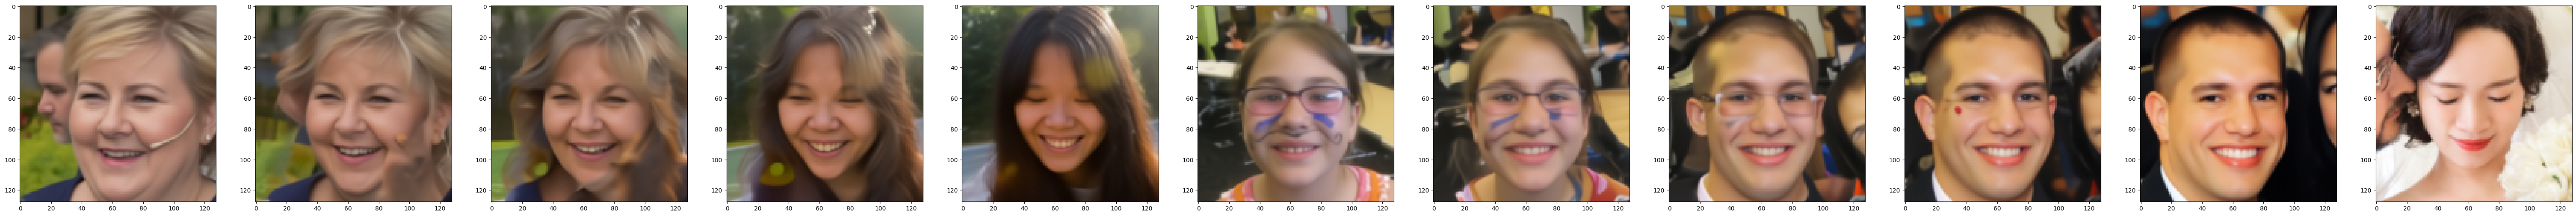

In [ ]:
batch = images[20:25]

batch_idxs = indices[20:25]

fakes, labels, pairs_morphed = get_partially_morphed(batch, batch_idxs, num_pairs=2)

fig, ax = plt.subplots(1, len(fakes), figsize=(7*len(fakes), 7))
for i in range(len(fakes)):
    ax[i].imshow(fakes[i].permute(1, 2, 0).cpu())
    # ax[i].set_title(alpha[i].item())

In [ ]:
print(labels, pairs_morphed, fakes.device)

tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.]) [tensor([58885., 14413.]), tensor([7664.,  183.])] cpu


In [ ]:
images = torch.tensor([])
labels = torch.tensor([])
pairs = torch.tensor([])
num_morphed = 0
for n,d in enumerate(dataloader):
    if n < 100: 
        images_ = d['img']
        indices_ = d['index']
        labels_ = torch.tensor([1]*len(images_))
        r = np.random.rand()
        print(n, round(r,3))
        if r > 0.7 and num_morphed < 500:
            images_, labels_, pairs_ = get_partially_morphed(images_, indices_, num_pairs=3)
            pairs_ = [[int(x) for x in p] for p in pairs_]
            print(n,"morphed:",*pairs_)
            pairs = torch.cat((pairs, torch.tensor(pairs_)))
            num_morphed += 9
        else:
            images_ = images_ / 2 + 0.5
        # print('\n',images_.shape, images.shape)
        
        labels = torch.cat((labels,labels_))
        images = torch.cat((images, images_))
    
    else: break

0 0.352
1 0.787
1 morphed: [44229, 36205] [2851, 49739] [59651, 34745]
2 0.106
3 0.912
3 morphed: [11226, 55958] [48117, 56041] [38684, 5363]
4 0.619
5 0.148
6 0.111
7 0.367
8 0.253
9 0.736
9 morphed: [68007, 43732] [54329, 31724] [13978, 55896]
10 0.81
10 morphed: [46053, 25301] [41712, 11106] [33504, 34664]
11 0.868
11 morphed: [22526, 33568] [18254, 66273] [14640, 62267]
12 0.154
13 0.797
13 morphed: [56790, 6609] [46317, 14298] [39430, 42519]
14 0.317
15 0.015
16 0.449
17 0.716
17 morphed: [45954, 53001] [32640, 22879] [28253, 47877]
18 0.291
19 0.65
20 0.096
21 0.974
21 morphed: [55843, 44059] [27472, 3744] [36739, 9177]
22 0.768
22 morphed: [38602, 53306] [49056, 66645] [37598, 18582]
23 0.81
23 morphed: [18372, 479] [51462, 66533] [53480, 16939]
24 0.833
24 morphed: [1502, 46639] [45891, 26000] [60159, 45824]
25 0.593
26 0.746
26 morphed: [67953, 10573] [58290, 14058] [19015, 50250]
27 0.089
28 0.551
29 0.454
30 0.253
31 0.892
31 morphed: [48506, 17726] [33381, 21171] [61330, 18

In [ ]:
print(len(images),len(pairs),len(labels))

1270 90 1270


In [ ]:
# !mkdir "/content/drive/Shareddrives/Colab Stuff/Hemant/data"

In [ ]:
# for n,im in enumerate(tqdm(images)):
    # if (im < 0).any(): im = im/2 + 0.5

    # plt.imsave(f'/content/drive/Shareddrives/Colab Stuff/Hemant/data/{n}_{labels[n]}.png',im.permute(1,2,0).numpy().astype(np.float16))

100%|██████████| 1270/1270 [00:24<00:00, 52.82it/s]


In [ ]:
# np.save(f'/content/drive/Shareddrives/Colab Stuff/Hemant/data/pairs.npy', pairs.numpy().astype(int))

In [3]:
from collections import Counter

In [4]:
# Discriminator

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #128 x 128 x 32
        self.mp1=nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #64 x 64 x 64
        self.mp2=nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) #32 x 32 x 128
        self.mp3=nn.MaxPool2d(2, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) #16 x 16 x 256
        self.mp4=nn.MaxPool2d(2, stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1) #8 x 8 x 512
        self.mp5=nn.MaxPool2d(2, stride=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(512*4*4, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = self.mp3(x)
        x = F.relu(self.conv4(x))
        x = self.mp4(x)
        x = F.relu(self.conv5(x))
        x = self.mp5(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.softmax(x)

        return x

In [5]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.auto import tqdm

In [26]:
imlist = os.listdir("/content/drive/Shareddrives/Colab Stuff/Hemant/data/")[:54]
try: imlist.remove("pairs.npy")
except ValueError: pass
labels = torch.tensor([int(i.split("_")[1][0]) for i in imlist][:36] + [0] * 18)
tensory = F.one_hot(labels)

In [30]:
images = torch.tensor([])
for pth in tqdm(imlist):
    images = torch.cat((images, torch.tensor(plt.imread(f"/content/drive/Shareddrives/Colab Stuff/Hemant/data/{pth}",format='RGB'), dtype=torch.float16).permute(2,0,1)[None,:]))

images = images[:,:3,:,:]

  0%|          | 0/54 [00:00<?, ?it/s]

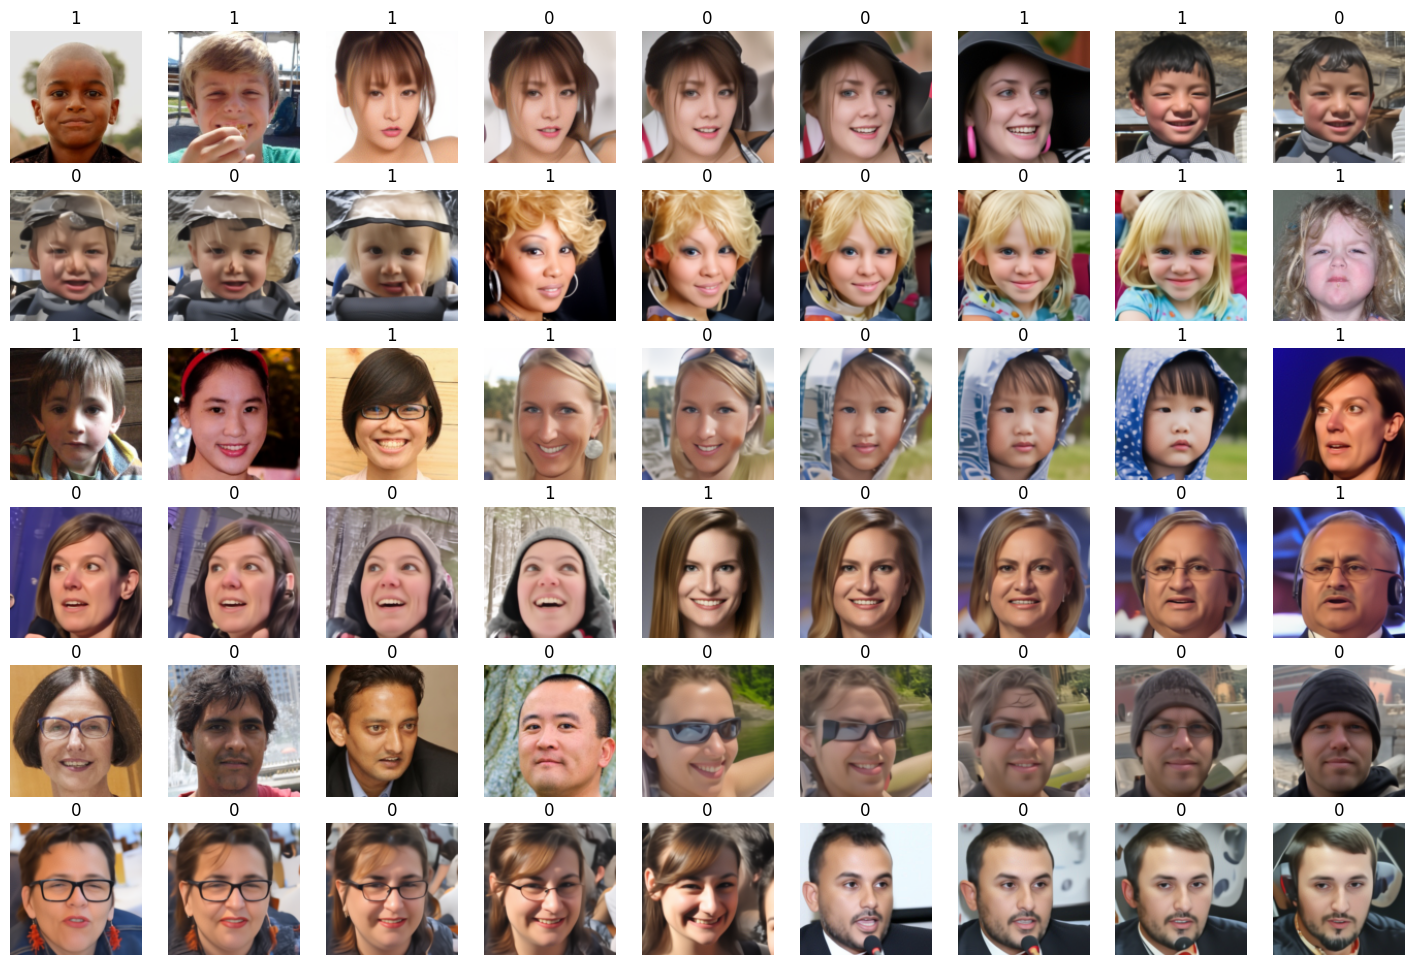

In [59]:
ax = plt.subplots(6,9,figsize=(18,12))[1].flatten()
axes_off = np.vectorize(lambda ax:ax.axis('off'))

axes_off(ax)
for i, im in enumerate(images):
    ax[i].imshow(im.permute(1,2,0))
    ax[i].set_title(labels[i].item())

In [35]:
n_samp = 18

subsamples = images[labels == 1][:n_samp]
subsamples_ = images[labels == 0][:n_samp]
sublab = labels[labels == 1][:n_samp]
sublab_ = labels[labels == 0][:n_samp]

subimages = torch.cat((subsamples,subsamples_))
sublabels = torch.cat((sublab, sublab_))
randperm = torch.randperm(len(subimages))
subimages = subimages[randperm]
sublabels = sublabels[randperm]

In [36]:
images = images[:,:3,:,:]

In [51]:
import torch.optim as optim

disc = Discriminator().cuda()
criterion = nn.BCELoss()
optimizer = optim.SGD(disc.parameters(), lr=10)

In [ ]:
losses = []
for epoch in range(10):  # loop over the dataset multiple times
    iter_losses = []
    for i in range(0,len(images),2):
        x, y = images[i:i+2].float().cuda(), tensory[i:i+2].float().cuda()

        optimizer.zero_grad()
        outputs = disc(x)

        loss = criterion(outputs, y)
        loss.retain_grad()
        loss.backward()
        # print(disc.weight.grad)
        optimizer.step()
        
        iter_losses.append(loss.item())

        # print(y, outputs)

    losses.append(np.mean(iter_losses))
    print(loss.item())

print('Finished Training')